## Setup the notebook

In [1]:
import os, sys

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
    from kaggle_secrets import UserSecretsClient
    import subprocess
    
    user_secrets = UserSecretsClient()
    token = user_secrets.get_secret("git_token")
    
    repo_url = f"git+https://{token}@github.com/Blaku03/PitchAnalyzer_AI.git"
    
    subprocess.check_call(
        ["pip", "install", repo_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.STDOUT
    )
    video_path = "/kaggle/input/pitchtest/B1606b0e6_1 (91).mp4"
    output_path = "./output_video.avi"
else:
    # reloads the code during development
    %load_ext autoreload
    %autoreload 2
    # ensure project root (one level up) is on PATH
    ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if ROOT not in sys.path:
        sys.path.insert(0, ROOT)

    video_path = "../sample_data/B1606b0e6_1 (91).mp4"
    output_path = "../output_videos/output_video.avi"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

## Import the model

In [2]:
from utils.import_models import ModelImporter
players_model = ModelImporter().download_player_model()

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1


## Sanity check on the first frame


0: 544x960 1 ball, 22 players, 1 referee, 32.7ms
1: 544x960 2 goalkeepers, 22 players, 2 referees, 32.7ms
2: 544x960 1 ball, 21 players, 2 referees, 32.7ms
3: 544x960 1 ball, 1 goalkeeper, 22 players, 1 referee, 32.7ms
4: 544x960 1 ball, 21 players, 2 referees, 32.7ms
5: 544x960 1 ball, 20 players, 2 referees, 32.7ms
6: 544x960 1 ball, 1 goalkeeper, 22 players, 1 referee, 32.7ms
7: 544x960 2 balls, 1 goalkeeper, 21 players, 1 referee, 32.7ms
8: 544x960 1 ball, 1 goalkeeper, 22 players, 2 referees, 32.7ms
9: 544x960 1 ball, 21 players, 1 referee, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 29.1ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 21 players, 2 referees, 33.2ms
1: 544x960 22 players, 2 referees, 33.2ms
2: 544x960 20 players, 2 referees, 33.2ms
3: 544x960 1 ball, 20 players, 2 referees, 33.2ms
4: 544x960 1 ball, 20 players, 2 referees, 33.2ms
5: 544x960 20 players, 2 referees, 33.2ms
6: 544x960 1 ball, 20 players, 2 referees, 33.2ms
7: 544x960 1 ball, 20 p

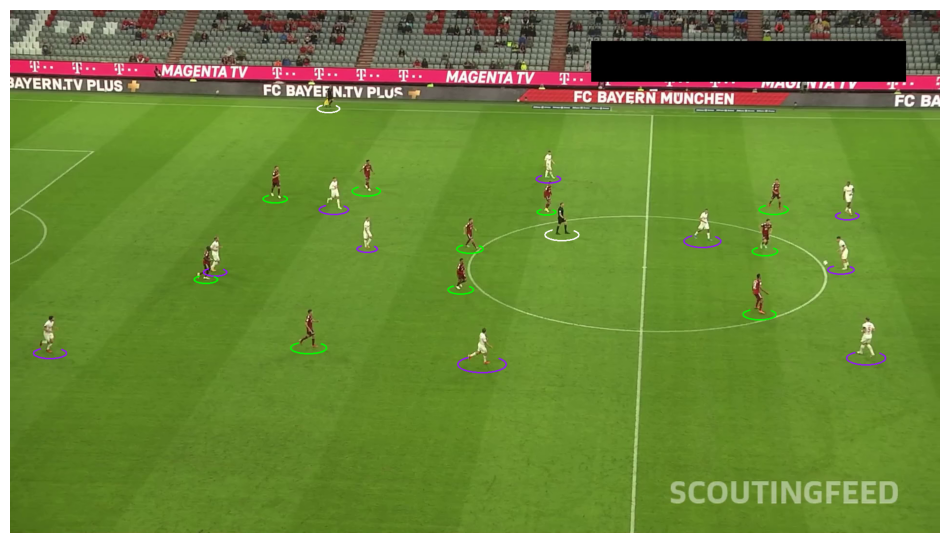

In [3]:
from annotators.player_annotator import PlayersAnnotator
from trackers.game_tracker import GameTracker
from utils.notebook_utils import show_image
from utils.video_utils import read_video

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)

first_frame = next(frame_generator)
first_players_tracks = next(tracks_generator)

annotated_sample_image = PlayersAnnotator.annotate_frame(first_frame, first_players_tracks)
show_image(annotated_sample_image)

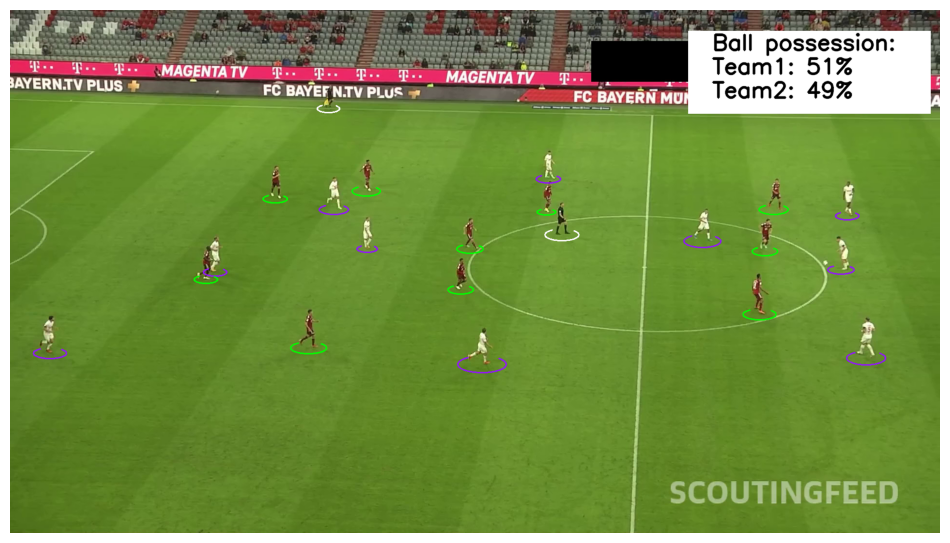

In [4]:
import supervision as sv
from utils.video_utils import add_text_to_image

rect = sv.Rect(x=1400,y=45,width=500,height=170)

scene = sv.draw_filled_rectangle(scene=first_frame.copy(),rect=rect,color=sv.Color.WHITE)

text =  "Ball possession: \nTeam1: 51%\nTeam2: 49%"
scene = add_text_to_image(
    image_rgb=scene,
    label=text,
    font_thickness=3,
    font_scale=1.5,
    top_left_xy=(1450, 50),
    font_color_rgb=(0, 0, 0)
)

show_image(scene)

In [5]:
from trackers.statistics_tracker import StatisticsTracker

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)
stats_tracker = StatisticsTracker()
for track in tracks_generator:
    print(stats_tracker.update_with_detections(track))


0: 544x960 1 ball, 1 goalkeeper, 24 players, 1 referee, 32.0ms
1: 544x960 1 ball, 1 goalkeeper, 21 players, 1 referee, 32.0ms
2: 544x960 1 ball, 1 goalkeeper, 21 players, 32.0ms
3: 544x960 2 balls, 21 players, 2 referees, 32.0ms
4: 544x960 1 ball, 1 goalkeeper, 24 players, 1 referee, 32.0ms
5: 544x960 2 balls, 1 goalkeeper, 21 players, 3 referees, 32.0ms
6: 544x960 21 players, 2 referees, 32.0ms
7: 544x960 1 ball, 1 goalkeeper, 23 players, 32.0ms
8: 544x960 21 players, 1 referee, 32.0ms
9: 544x960 1 ball, 1 goalkeeper, 23 players, 1 referee, 32.0ms
Speed: 2.2ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 1 ball, 20 players, 2 referees, 33.3ms
1: 544x960 21 players, 2 referees, 33.3ms
2: 544x960 22 players, 2 referees, 33.3ms
3: 544x960 20 players, 2 referees, 33.3ms
4: 544x960 1 ball, 20 players, 2 referees, 33.3ms
5: 544x960 1 ball, 20 players, 2 referees, 33.3ms
6: 544x960 20 players, 2 referees, 33.3ms
7: 544x960 1 ball, 20 player

## Annotate the provided video

In [ ]:
from utils.video_utils import save_video
import itertools
from annotators.statistics_annotator import StatisticsAnnotator

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)

track_gen1, track_gen2 = itertools.tee(tracks_generator)

stats_generator = StatisticsTracker().get_statictics_generator(track_gen1)

frame_generator = read_video(video_path)
annotated_players_frames_generator = PlayersAnnotator.annotate_video(frame_generator, track_gen2)
annotated_statictics_fames_generator = StatisticsAnnotator.annotate_video(annotated_players_frames_generator, stats_generator)
save_video(annotated_statictics_fames_generator, output_path)


0: 544x960 21 players, 1 referee, 32.2ms
1: 544x960 2 balls, 21 players, 1 referee, 32.2ms
2: 544x960 1 ball, 1 goalkeeper, 22 players, 32.2ms
3: 544x960 1 ball, 1 goalkeeper, 23 players, 1 referee, 32.2ms
4: 544x960 1 goalkeeper, 22 players, 1 referee, 32.2ms
5: 544x960 1 ball, 21 players, 2 referees, 32.2ms
6: 544x960 1 ball, 1 goalkeeper, 23 players, 1 referee, 32.2ms
7: 544x960 1 goalkeeper, 25 players, 1 referee, 32.2ms
8: 544x960 1 goalkeeper, 24 players, 1 referee, 32.2ms
9: 544x960 21 players, 3 referees, 32.2ms
Speed: 2.2ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 1 ball, 20 players, 2 referees, 33.4ms
1: 544x960 21 players, 2 referees, 33.4ms
2: 544x960 22 players, 2 referees, 33.4ms
3: 544x960 20 players, 2 referees, 33.4ms
4: 544x960 1 ball, 20 players, 2 referees, 33.4ms
5: 544x960 1 ball, 20 players, 2 referees, 33.4ms
6: 544x960 20 players, 2 referees, 33.4ms
7: 544x960 1 ball, 20 players, 2 referees, 33.4ms
8: 544x